# Turbine Map Plotting Tool (Fixed Geometry)

In [1]:
"""
===-*- Turbine Map Plotting Tool Fixed Geometry -*-===
=====-*- General -*-=====
Copyright (c) makkiblog.com
MIT License 
coding: utf-8

===-*- VERSION -*-===
v0.1 Initial Release
vvvCODEvvv
"""

#Setup
import numpy as np
from pylab import *
from scipy import signal
from scipy import interpolate
from scipy import integrate
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
import pandas as pd
import math
from scipy.optimize import curve_fit
import os
import sys
import configparser
import codecs
import csv
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

#mpl.rcParams['agg.path.chunksize'] = 100000

In [2]:
#Setup (Visual)
import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style('whitegrid')

plt.rcParams["figure.figsize"] = (16,9)
plt.rcParams['figure.facecolor'] = 'white'

#colormap settings
#define legend colormap
cmap = plt.cm.gist_ncar
cmap2 = plt.cm.cool    

### FileRead

In [3]:
def csv_df(input):
    return pd.read_csv('./Datas/' + input+'.csv', header=0,index_col=False)

def txt_df(input):   
    return pd.read_table('./Datas/' + input+'.txt', header=0,index_col=False)


### Curvefit Function

In [4]:
#============DEFINE CURVEFIT Method===================
#====================NOT USED=========================
#Reference: https://rikei-fufu.com/2020/07/05/post-3270-fitting/

def fitfunc(x,c0,c1,c2,c3,c4): # logarithmic function
    y = c0*np.log10(x)**4+c1*np.log10(x)**3+c2*np.log10(x)**2+c3*np.log10(x)+c4
    return y
    
def fitting_curve(in_df):
    x_obs = in_df['PRT']
    y_obs = in_df['Q']
    
    #main calc
    popt, pcov = curve_fit(fitfunc, x_obs, y_obs, full_output=False) 
    perr = np.sqrt(np.diag(pcov)) 
 
    
    #Chi2 contingency
    o = y_obs
    e = fitfunc((x_obs), popt[0], popt[1], popt[2], popt[3], popt[4]) 
    chi2 = stats.chisquare(o, f_exp = e, ddof=4) #ChiSq. Calc: Output: [chi**2, p value]
 
    #R2 calc
    residuals =  o - e 
    rss = np.sum(residuals**2)      #: residual sum of squares = rss
    tss = np.sum((o-np.mean(o))**2) #: total sum of squares = tss
    r_squared = 1 - (rss / tss)     #R^2
    statistics_numbers = {  "X-squared": format(chi2[0], '.3f'),
                            "p-value": format(chi2[1], '.5f'),
                            "R^2": format(r_squared, '.4f')}

    #Print results
    print("==========Fit Result============")
    print("y = c0 + c1*log10(x)**2+c2*log10(x)")
    print("Constants:",popt)
    print('Error:',perr)   
    print("X-squared, p-value, R^2:", statistics_numbers)
    print("=============EOF=============") 
    
    return popt,r_squared

def fitting_result(x,Cs):
    y = Cs[0]*np.log10(x)**4+Cs[1]*np.log10(x)**3+Cs[2]*np.log10(x)**2+Cs[3]*np.log10(x)+Cs[4]
    return y

### Fit Map

In [5]:
def fit_map(df):
    n=100
    popt, r_squared = fitting_curve(df)
    res_df = pd.DataFrame(columns=['PRT','Q'])
    
    xarr = np.linspace(df['PRT'].min(), df['PRT'].max(), n)
    for x in xarr:
        y = fitting_result(x,popt)
        nl=pd.Series({'PRT':x,'Q':y})
        res_df = res_df.append(nl,ignore_index=True)
    return res_df, r_squared


### SETTINGS

In [6]:
#Turbine Map and lugline plotting
def text_plot_all(case,vanename,rpmname,flowname,ername,etaname,luglines):
    df_b = txt_df(case)
    clf()
    plt.figure()   
    df_b.set_index(ername, inplace=True)

    #plot lugline
    i = 0
    for lugline in luglines:
        target = csv_df(luglines[i])
        plot(target['PRT'],target['Q'],label=str(luglines[i]))    
        i+=1

    #plot curve fit contour line
    res_line, r_squared = fit_map(txt_df(case))
    plot(res_line['PRT'],res_line['Q'],linestyle='dotted',label=('TurbineMap_R^2:%.3f' % (r_squared)),color='blue')
    plt.legend()

    #Plot data lines
    ydata_df = df_b.groupby([rpmname,vanename])       
    for key, item in ydata_df:
        ydata_df.get_group(key)[flowname].plot(legend=False,color='blue')    

    plt.title('PRT-Flow plot for ' + case)
    plt.ylabel('Flow [kg/s]')
    plt.xlabel('PRT')
    name = str(case)
    plt.savefig('./Datas/' + name + '_PRT_Flow_vane.png', dpi=300)
    plt.show()

    
#Turbine PRT and efficiency plotting
def text_plot_PRT(case,vanename,rpmname,flowname,ername,etaname,note,PRT):
    df_b = txt_df(case)
    name = str(case)
    vanepos = list()
    rpms = list()
    mapdata = list()
    mapcounts=list()
    rpmmap=list()
    vanemap=list()
    count=0
    etatmap=list()
    flowtmap=list()
    
    for g, data in df_b.groupby([vanename,rpmname]):
        mapdata.append(data)
        vanepos.append(data[vanename].iloc[0])
        rpms.append(data[rpmname].iloc[0])
        mapcounts.append(count)
        count+=1
    maxrpmcorr=max(rpms)
    
    for g, data in df_b.groupby([vanename]):
        vanemap.append(data)
    

    #plotting for each vane position
    clf()
    plt.figure()  
    plt.title('Flow-Eta plot for PRT' + str(PRT))
    plt.xlabel('Flow [kg/s]')
    plt.ylabel('etaT')
    name = str(case)
    
    j=0
    while j < len(vanemap):
        vaneopening=vanemap[j][vanename].iloc[0]
        rpmmap.clear()
        for g, data in vanemap[j].groupby([rpmname]):
            rpmmap.append(data)
    
        #Obtaining each etaT for deinfed PRT for plotting each rpm set
        k=0       
        etatmap.clear()
        flowtmap.clear()
        while k < len(rpmmap):
            flowlist=rpmmap[k][flowname].to_list()
            prtlist=rpmmap[k][ername].to_list()
            etalist=rpmmap[k][etaname].to_list()
            etatj = np.interp(PRT,prtlist,etalist)
            flowtj = np.interp(PRT,prtlist,flowlist)
            etatmap.append(etatj)
            flowtmap.append(flowtj)
            #scatter(flowtmap,etatmap,color=cmap2(vaneopening))
            plot(flowtmap,etatmap,color=cmap2(vaneopening))
            k+=1
        j+=1
    plt.savefig('./Datas/' + name + 'EtaT_Flow_PRT' + str(PRT) + '.png', dpi=300)



### Plot Data

==========Fit Result============
y = c0 + c1*log10(x)**2+c2*log10(x)
Constants: [-1.28179123  2.18964552 -1.64919072  0.62006324  0.0417512 ]
Error: [0.46906634 0.5850506  0.25253644 0.04380394 0.00251165]
X-squared, p-value, R^2: {'X-squared': '0.000', 'p-value': '1.00000', 'R^2': '0.9978'}
=============EOF=============


<Figure size 1152x648 with 0 Axes>

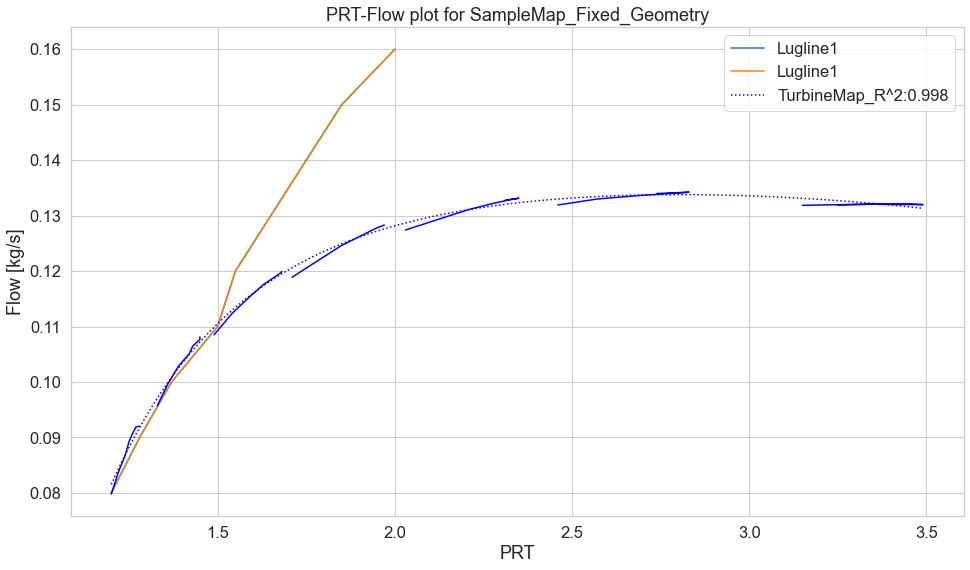

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

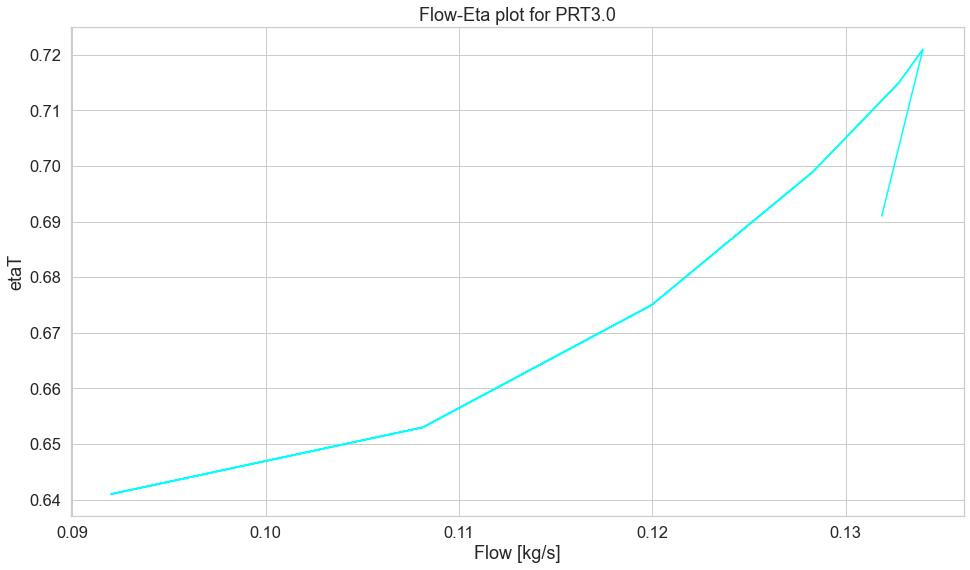

In [7]:
MapTitle='SampleMap_Fixed_Geometry'
var1='Nozzle'
var2='RPM'
var3='Q'
var4='PRT'
var5='EtaT'
luglines = ['Lugline1','Lugline1']

text_plot_all(MapTitle,var1,var2,var3,var4,var5,luglines)
text_plot_PRT(MapTitle,var1,var2,var3,var4,var5,'note',1.5)
text_plot_PRT(MapTitle,var1,var2,var3,var4,var5,'note',2.0)
text_plot_PRT(MapTitle,var1,var2,var3,var4,var5,'note',2.5)
text_plot_PRT(MapTitle,var1,var2,var3,var4,var5,'note',3.0)
